(gallery-shapes-superpos)=

# Superposition

The [superposition principle](https://en.wikipedia.org/wiki/Superposition_principle) states that the net response caused by two or more stimuli is the sum of the responses caused by each stimulus individually. This principle holds in magnetostatics when there is no material response, and simply states that the total field created by multiple magnets and currents is the sum of the individual fields.

When two magnets overlap geometrically, the magnetization in the overlap region is given by the vector sum of the two individual magnetizations. This enables two geometric operations,

:::::{grid} 1 2 2 2
:gutter: 4

::::{grid-item-card} Union
:img-bottom: ../../_static/images/docu_field_superpos_union.png
:shadow: None
Build complex forms by aligning base shapes (no overlap) with each other with similar magnetization vector.
::::

::::{grid-item-card} Cut-Out
:img-bottom: ../../_static/images/docu_field_superpos_cutout.png
:shadow: None
When two objects with opposing magnetization vectors of similar amplitude overlap, they will just cancel in the overlap region. This enables geometric cut-out operations.
::::
:::::


## Union operation

Geometric union by superposition is demonstrated in the following example where a wedge-shaped magnet with a round back is constructed from three base-forms: a CylinderSegment, a Cuboid and a TriangularMesh.

In [1]:
import numpy as np
import magpylib as magpy

# Create three magnet parts with similar polarization
pt1 = magpy.magnet.CylinderSegment(
    polarization=(0.5, 0, 0),
    dimension=(0, 0.04, 0.02, 90, 270),
)
pt2 = magpy.magnet.Cuboid(
    polarization=(0.5, 0, 0), dimension=(0.02, 0.08, 0.02), position=(0.01, 0, 0)
)
pt3 = magpy.magnet.TriangularMesh.from_ConvexHull(
    polarization=(0.5, 0, 0),
    points=np.array(
        [(2, 4, -1), (2, 4, 1), (2, -4, -1), (2, -4, 1), (6, 0, 1), (6, 0, -1)]
    )
    / 100,
)

# Combine parts in a Collection
magnet = magpy.Collection(pt1, pt2, pt3)

# Add a sensor with path
sensor = magpy.Sensor()
sensor.position = np.linspace((7, -10, 0), (7, 10, 0), 100) / 100

# Plot
with magpy.show_context(magnet, sensor, backend="plotly", style_legend_show=False) as s:
    s.show(col=1)
    s.show(output="B", col=2)

## Cut-out operation

When two objects with opposing magnetization vectors of similar amplitude overlap, they will just cancel in the overlap region. This enables geometric cut-out operations. In the following example we construct an exact hollow cylinder solution from two concentric cylinder shapes with opposite magnetizations, and compare the result to the `CylinderSegment` class solution.

Here the `getM` and `getJ` functions come in handy. They allow us to see the magnetization distribution that is the result of the superposition.

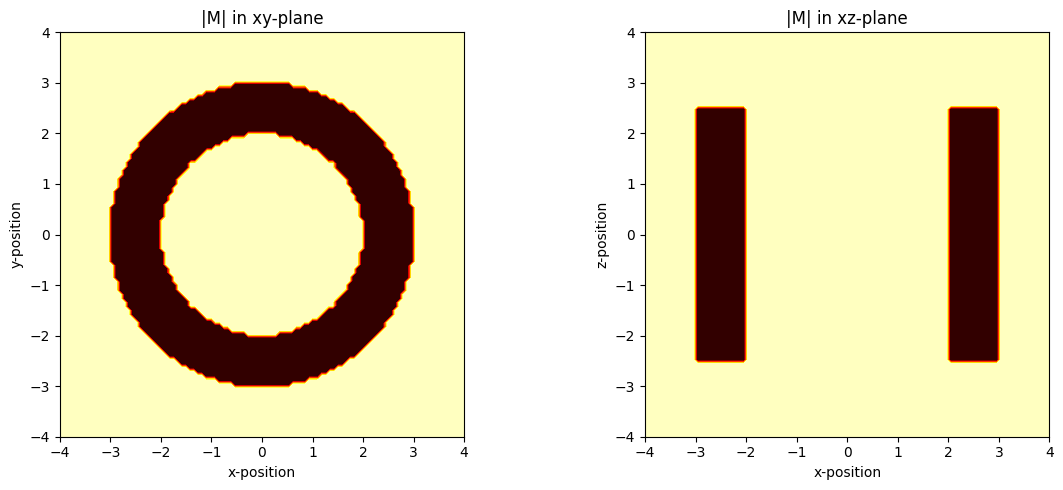

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import magpylib as magpy

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))

# Create an observer grid in the xy-symmetry plane
X, Y = np.mgrid[-4:4:100j, -4:4:100j].transpose((0, 2, 1))
grid_xy = np.stack([X, Y, np.zeros((100, 100))], axis=2)
grid_xz = np.stack([X, np.zeros((100, 100)), Y], axis=2)

# Create ring with cut-out
inner = magpy.magnet.Cylinder(polarization=(0, 0, -1), dimension=(4, 5))
outer = magpy.magnet.Cylinder(polarization=(0, 0, 1), dimension=(6, 5))
ring0 = inner + outer

# Compute J-field of ring
M_xy = np.linalg.norm(ring0.getM(grid_xy), axis=2)
M_xz = np.linalg.norm(ring0.getM(grid_xz), axis=2)

# Display field with Pyplot
ax1.contourf(grid_xy[:, :, 0], grid_xy[:, :, 1], M_xy, cmap=plt.cm.hot_r)
ax2.contourf(grid_xz[:, :, 0], grid_xz[:, :, 2], M_xz, cmap=plt.cm.hot_r)

# plot styling
ax1.set(
    title="|M| in xy-plane",
    xlabel="x-position",
    ylabel="y-position",
    aspect=1,
    xlim=(-4,4),
    ylim=(-4,4),
)
ax2.set(
    title="|M| in xz-plane",
    xlabel="x-position",
    ylabel="z-position",
    aspect=1,
    xlim=(-4,4),
    ylim=(-4,4),
)

plt.tight_layout()
plt.show()

The two figures show that the magnetization is zero outside of the cylinder, as well as in the overlap region where the two magnetizations cancel.

Finally we want to show that the superposition gives the same result as a computation from the CylinderSegment solution.

In [3]:
from magpylib.magnet import Cylinder, CylinderSegment

# Create ring with CylinderSegment
ring1 = CylinderSegment(polarization=(0, 0, .1), dimension=(2, 3, 5, 0, 360))

# Print results
print("CylinderSegment result:", ring1.getB((.01, .02, .03)))
print("        Cut-out result:", ring0.getB((.01, .02, .03)))

CylinderSegment result: [-2.23052304e-07 -4.46104607e-07 -1.40679580e-02]
        Cut-out result: [-2.23052304e-06 -4.46104607e-06 -1.40679580e-01]


Note that, it is faster to compute the `Cylinder` field two times than computing the `CylinderSegment` field one time. This is why Magpylib automatically falls back to the `Cylinder` solution whenever `CylinderSegment` is called with 360 deg section angles.

Unfortunately, with respect to 3D-models, cut-out operations cannot be displayed graphically at the moment, but {ref}`examples-own-3d-models` offer custom solutions.

## Nice example

The following example combines union and cut-out to create a complex magnet shape which is then displayed by combining a streamplot with a contourplot in matplotlib.

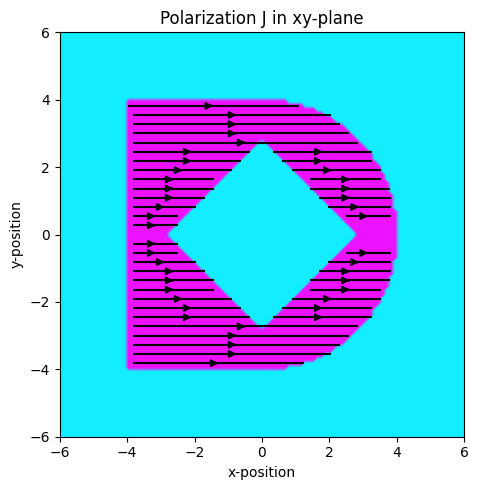

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import magpylib as magpy

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# Create a magnet with superposition and cut-out
pt1 = magpy.magnet.Cuboid(
    polarization=(1, 0, 0), dimension=(4, 8, 2), position=(-2, 0, 0)
)
pt2 = magpy.magnet.CylinderSegment(
    polarization=(1, 0, 0), dimension=(0, 4, 2,-90,90)
)
pt3 = magpy.magnet.Cuboid(
    polarization=(-1/np.sqrt(2), 1/np.sqrt(2), 0), dimension=(4, 4, 2),
).rotate_from_angax(45, 'z')
magnet = magpy.Collection(pt1, pt2, pt3)

# Compute J on mesh and plot with streamplot
X, Y = np.mgrid[-6:6:100j, -6:6:100j].transpose((0, 2, 1))
grid = np.stack([X, Y, np.zeros((100, 100))], axis=2)

J = magnet.getJ(grid)
J[J<1e-12] = 0 # cut off numerically small values

ax.contourf(grid[:, :, 0], grid[:, :, 1], np.linalg.norm(J,axis=2), cmap=plt.cm.cool)
ax.streamplot(
    grid[:, :, 0],
    grid[:, :, 1],
    J[:, :, 0],
    J[:, :, 1], color='k', density=1.5,
)

# plot styling
ax.set(
    title="Polarization J in xy-plane",
    xlabel="x-position",
    ylabel="y-position",
    aspect=1,
)
plt.tight_layout()
plt.show()